# Pilot Subjects Analysis

Dataset gathered from pilot subjects. All subjects were healthy adults. **TODO - ADD DESCRIPTION FOR PILOT SUBJECTS**

<img src="images/ddm_desc.jpeg" width="600">

Here, we use the `hddm` (Python) library$^1$ to model language-based decision making based on response-time & accuracy data from a binary forced-choice decision task. During each trial, subjects were presented with a digital image of an item (visual stimulus) and a verbal description (auditory stimulus). At the end of each trial, subjects were asked to indicate whether the two types of stimuli agreed (i.e. visual and auditory stimulus pointed to the same object) or were different (i.e. non-matching sound and image). Auditory and visual stimuli pairs fell under four distinct categories, as summarised below:  
- Condition 1 (**SS**): Same stimuli (see cat / hear cat)
- Condition 2 (**CP**): Phonologically congruent (see cat / hear hat)
- Condition 3 (**CS**): Semantically congruent (see cat / hear dog)
- Condition 4 (**US**): Unrelated stimuli (see house / hear cat)

In [2]:
"""
Environment setup
"""
%matplotlib inline
%cd ~/Programming/projects/language_decision/
import warnings; warnings.filterwarnings('ignore')
import hddm
import numpy as np
import matplotlib.pyplot as plt

/Users/celefthe/Programming/projects/language_decision


In [3]:
"""
Plot Drift Diffusion Model for pilot subjects data
"""

pilot_subjects = hddm.load_csv('data/pilot_clean.csv')

# Test if stimulus type affects drift rate
model = hddm.HDDM(pilot_subjects, depends_on={'v': 'stim'})
model.find_starting_values()
model.sample(6000, burn=20)

 [-----------------100%-----------------] 6000 of 6000 complete in 258.1 sec

## Convergence Checks

Before carrying on with analysing the output of the model, we need to check that the markov chains have properly converged. There's a number of ways to do this, which the authors of the `hddm` library recommend$^1$. We'll begin by visually inspecting the MCMC posterior plots. 

Plotting a
Plotting a_std
Plotting v(CP)
Plotting v(CS)
Plotting v(SS)
Plotting v(US)
Plotting v_std
Plotting t
Plotting t_std


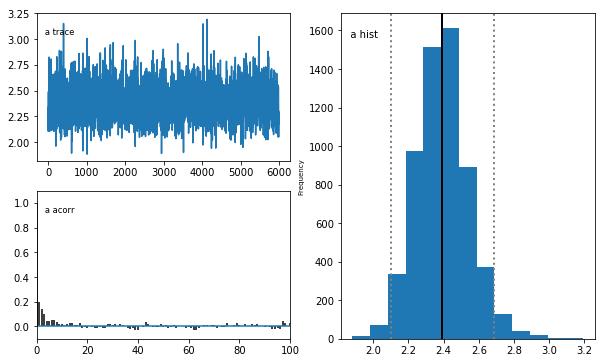

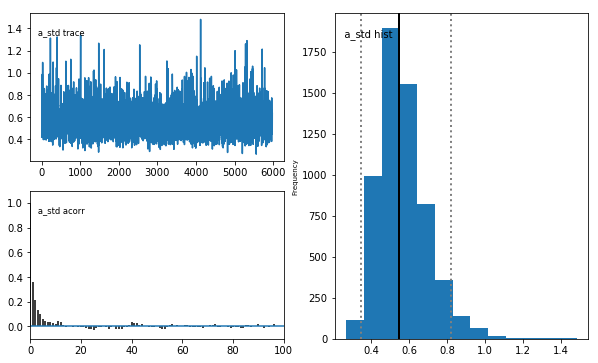

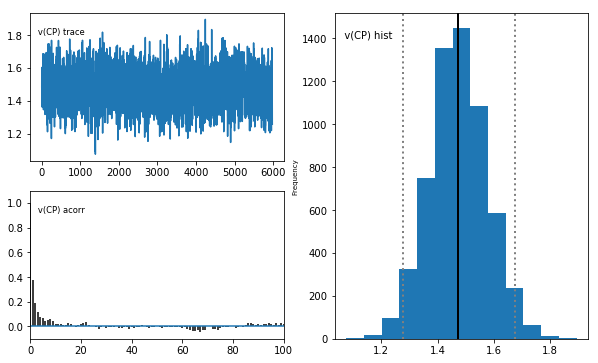

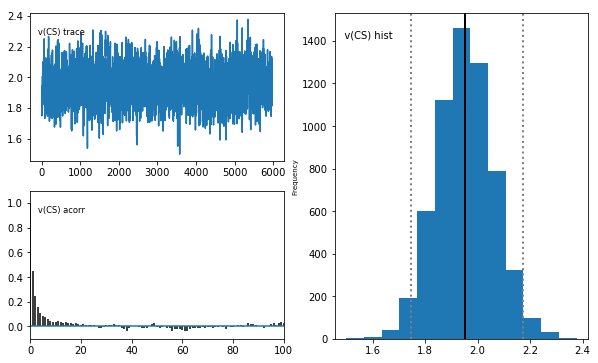

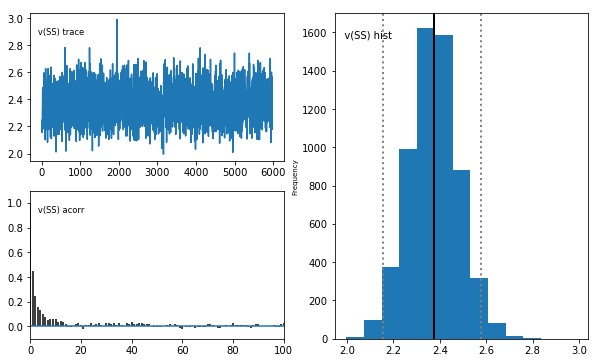

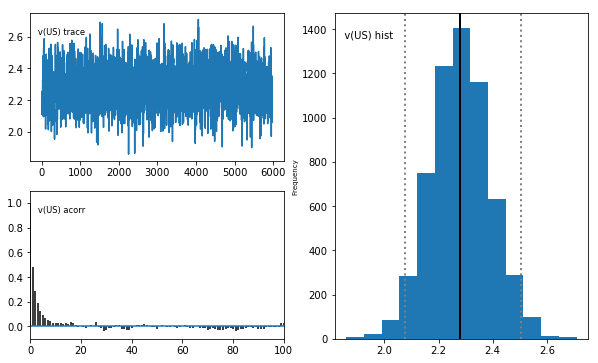

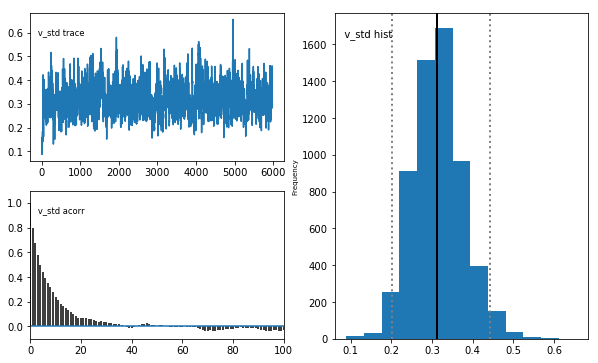

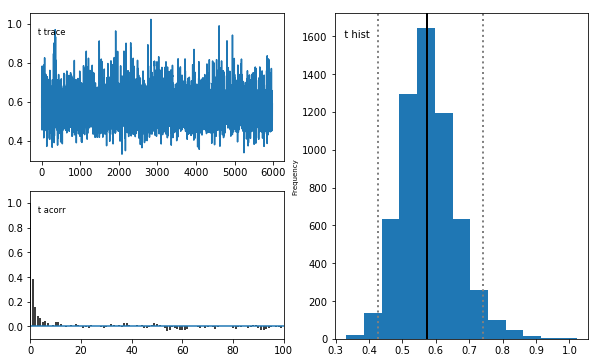

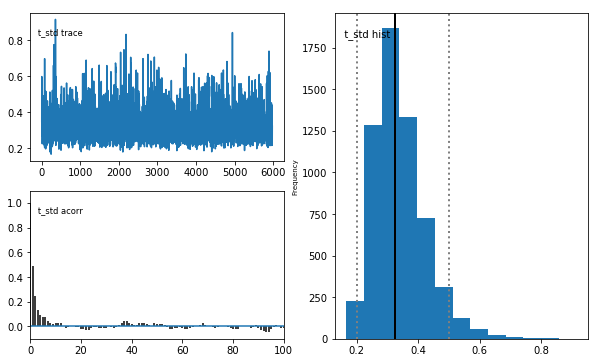

In [4]:
model.plot_posteriors()

**PASS** - No problematic patterns, such as drifts or large jumps, can be in any of the traces above. Autocorrelation also drops to zero quite quickly when considering past samples - which is what we want.

We can also formally test for model convergence using the Gelman-Rubin R statistic$^2$, which compares the within- and between-chain variance of different runs of the same model; models converge if variables are between $0.98$ and $1.02$. A simple algorithm to check this is outlined below:

In [15]:
models = []
for i in range(5):
    m = hddm.HDDM(pilot_subjects, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(6000, burn=20)
    models.append(m)

gelman_rubin = hddm.analyze.gelman_rubin(models)

for key, value in gelman_rubin.items():
    if (value > 1.02) or (value < 0.98):
        print("Convergence error at " + str(key))
        break
else
    print("\nNo convergence problems detected!")

 [-----------------100%-----------------] 6000 of 6000 complete in 258.1 sec
No convergence problems detected!


**PASS** - Formal testing reveals no convergence problems; Gelman-Rubin R statistic values for all model variablesfall within the desired range ($0.98$ to $1.02$)

## Drift Rate Analysis

Here, we examine whether the type of stimulus significantly affects the drift rate of the decision-making process.

In [21]:
model_stats = model.gen_stats()
print("Threshold (a) Mean: " + str(model_stats['mean']['a']) + " (std: " + str(model_stats['std']['a']) + ")")
print("SS Mean Drift Rate: " + str(model_stats['mean']['v(SS)']) + " (std: " + str(model_stats['std']['v(SS)']) + ")")
print("CP Mean Drift Rate: " + str(model_stats['mean']['v(CP)']) + " (std: " + str(model_stats['std']['v(CP)']) + ")")
print("CS Mean Drift Rate: " + str(model_stats['mean']['v(CS)']) + " (std: " + str(model_stats['std']['v(CS)']) + ")")
print("US Mean Drift Rate: " + str(model_stats['mean']['v(US)']) + " (std: " + str(model_stats['std']['v(US)']) + ")")

Threshold (a) Mean: 2.39349715299 (std: 0.149985138992)
SS Mean Drift Rate: 2.37418163966 (std: 0.10716170321)
CP Mean Drift Rate: 1.47436478894 (std: 0.102097049936)
CS Mean Drift Rate: 1.95254140701 (std: 0.108572726137)
US Mean Drift Rate: 2.28151777973 (std: 0.110047907095)


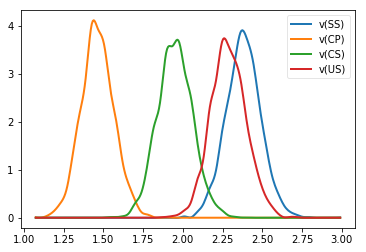

In [22]:
v_SS, v_CP, v_CS, v_US = model.nodes_db.node[['v(SS)', 'v(CP)', 'v(CS)', 'v(US)']]

hddm.analyze.plot_posterior_nodes([v_SS, v_CP, v_CS, v_US])

Estimating the model in a Bayesian framework allows us to test for significance directly on the posterior, rather than having to rely on conventional frequency statistical tests:

In [23]:
print('P(SS > US) = ' + str((v_SS.trace() > v_US.trace()).mean()))
print('P(CP > SS) = ' + str((v_CP.trace() > v_SS.trace()).mean()))
print('P(CS > SS) = ' + str((v_CS.trace() > v_SS.trace()).mean()))
print('P(CP > CS) = ' + str((v_CP.trace() > v_CS.trace()).mean()))

P(SS > US) = 0.740133779264
P(CP > SS) = 0.0
P(CS > SS) = 0.00267558528428
P(CP > CS) = 0.00100334448161


- The drift rate for **CP** is significantly lower than all other conditions  
- The drift rate for **CS** is significantly lower than **SS** and **US**, but significantly higher than **CP**  
- The drift rates for **SS** and **US** are not significantly different  

### Reaction Time & Accuracy 

Here we include the reaction time and accuracy metrics from the original dataset

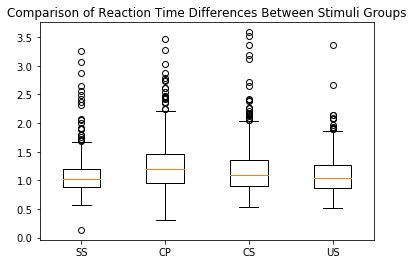

In [28]:
us = pilot_subjects.loc[pilot_subjects['stim'] == 'US']
ss = pilot_subjects.loc[pilot_subjects['stim'] == 'SS']
cp = pilot_subjects.loc[pilot_subjects['stim'] == 'CP']
cs = pilot_subjects.loc[pilot_subjects['stim'] == 'CS']

plt.boxplot([ss.rt.values, cp.rt.values, cs.rt.values, us.rt.values], 
            labels=('SS', 'CP', 'CS', 'US'),)
plt.title('Comparison of Reaction Time Differences Between Stimuli Groups')
plt.show()

In [59]:
ss_accuracy = (len([x for x in ss.response.values if x >= 1]) / len(ss.response.values)) * 100 
cp_accuracy = (len([x for x in cp.response.values if x >= 1]) / len(cp.response.values)) * 100
cs_accuracy = (len([x for x in cs.response.values if x >= 1]) / len(cs.response.values)) * 100
us_accuracy = (len([x for x in us.response.values if x >= 1]) / len(us.response.values)) * 100

print("SS Accuracy: " + str(ss_accuracy) + "%")
print("CP Accuracy: " + str(cp_accuracy) + "%")
print("CS Accuracy: " + str(cs_accuracy) + "%")
print("US Accuracy: " + str(us_accuracy) + "%")

SS Accuracy: 98.12108559498957%
CP Accuracy: 92.08333333333333%
CS Accuracy: 98.52941176470588%
US Accuracy: 99.37369519832986%


## Bias Analysis

*Bias* (or *z*) describes the relative difference in the distance between the upper and lower response boundaries of the DDM, such that the sum of accumulated data required to reach one decision boundary differs from the other.

We explore whether stimulus type affects bias, such that the decision making process would favour a particular threshold for a given stimulus type.

In [60]:
model_bias = hddm.HDDM(pilot_subjects, depends_on={'v': 'stim', 'z': 'stim'}, bias=True)
model_bias.find_starting_values()
model_bias.sample(6000, burn=20)

 [-----------------100%-----------------] 6000 of 6000 complete in 411.1 sec

Confirm model convergence just to be sure:

In [62]:
models_bias = []
for i in range(5):
    m = hddm.HDDM(pilot_subjects, depends_on={'v': 'stim', 'z': 'stim'}, bias=True)
    m.find_starting_values()
    m.sample(6000, burn=20)
    models_bias.append(m)

bias_gelman_rubin = hddm.analyze.gelman_rubin(models_bias)

for key, value in bias_gelman_rubin.items():
    if (value > 1.02) or (value < 0.98):
        print("Convergence error at " + str(key))
        break
else:
    print("\nNo convergence problems detected!")

 [-----------------100%-----------------] 6000 of 6000 complete in 411.1 sec
No convergence problems detected!


Since models converge, we can check the posteriors for significant differences in bias between stimuli groups as we did for drift rates.

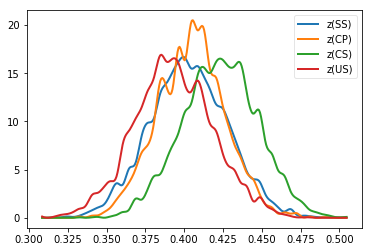

In [64]:
z_SS, z_CP, z_CS, z_US = model_bias.nodes_db.node[['z(SS)', 'z(CP)', 'z(CS)', 'z(US)']]

hddm.analyze.plot_posterior_nodes([z_SS, z_CP, z_CS, z_US])

In [66]:
print('P(SS > US) = ' + str((z_SS.trace() > z_US.trace()).mean()))
print('P(CP > SS) = ' + str((z_CP.trace() > z_SS.trace()).mean()))
print('P(CS > SS) = ' + str((z_CS.trace() > z_SS.trace()).mean()))
print('P(CP > CS) = ' + str((z_CP.trace() > z_CS.trace()).mean()))
print('P(CS > US) = ' + str((z_CS.trace() > z_US.trace()).mean()))

P(SS > US) = 0.628762541806
P(CP > SS) = 0.526588628763
P(CS > SS) = 0.748662207358
P(CP > CS) = 0.283779264214
P(CS > US) = 0.834615384615


No significant differences in bias found across the different groups.

## Conclusions

Overall, we've found that 

## References

[1] Wiecki TV, Sofer I and Frank MJ (2013). HDDM: Hierarchical Bayesian estimation of the Drift-Diffusion Model in Python. Front. Neuroinform. 7:14. doi: 10.3389/fninf.2013.00014

[2] Gelman, A., & Rubin, D. (1992). [Practical Markov Chain Monte Carlo]: Rejoinder: Replication without Contrition. Statistical Science, 7(4), 503-511.
